Используя знания из практической части урока и функцию blur_face (размытие), проведи следующий эксперимент:

    Найди фото любого известного актера или актрисы.

    Распознай лицо на фотографии. Выдели лицо овалом. Метод для рисования овала, найди самостоятельно.

    Выдели на изображении глаза. Выдели их кружком. Если ты чувствуешь в себе суперсилу и дополнительный бекграунд знаний, и хочешь получить больше баллов за задание, то нарисуй вместо кружков солнцезащитные очки (картинку очков можно найти в интернете, задача их правильно масштабировать и разместить).

    Все лицо кроме глаз необходимо "заблюрить" (размыть) с помощью функции. 

Оценка за задание:

    1 балл - задача решена с помощью куратора, лицо распознано прямоугольником, глаза кругом.

    2 балла - задача решена с незначительными подсказками куратора, лицо распознано прямоугольником или кругом, глаза кругом, лицо размыто.

    3 балла - задача решена самостоятельно, лицо распознано овалом, глаза кругом, удалось заблюрить лицо, не затронув глаза.

    4 балла - задача решена самостоятельно на 3 балла, удалось нарисовать очки с подсказкой куратора, недостаточна соблюдена симметрия расположения очков или недостаточно учтены их размеры.

    5 баллов - задача полностью решена самостоятельно, все пункты выполнены.

In [188]:
#Пререквизиты

import os
import random
import string
import requests

import cv2
import gdown
from matplotlib import pyplot
import numpy as np

# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline
#gdown.download('https://storage.yandexcloud.net/academy.ai/moustache.png', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/academy.ai/haarcascade_mcs_mouth.xml', None, quiet=True)

def download_image():
    url = input("URL: ").strip()

    if not url:     # пустая строка → выходим
        return None

    base = os.path.basename(url)

    if "." in base and base.rsplit(".", 1)[1].lower() in {"jpg", "jpeg", "png", "gif", "webp"}:
        filename = base
    else:
        name = "".join(random.choices(string.ascii_letters + string.digits, k=6))
        head = requests.head(url, timeout=5)
        ctype = head.headers.get("Content-Type", "").lower()

        if "jpeg" in ctype:
            ext = ".jpg"
        elif "png" in ctype:
            ext = ".png"
        elif "gif" in ctype:
            ext = ".gif"
        elif "webp" in ctype:
            ext = ".webp"
        else:
            ext = ".bin"

        filename = name + ext

    filepath = os.path.join("photos", filename)

    r = requests.get(url, timeout=30)
    with open(filepath, "wb") as f:
        f.write(r.content)

    return filepath


#ImageName = download_image()

# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска улыбок
classifier_smile = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_smile.xml")
# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")
# загрузка каскада Хаара для поиска рта
classifier_mouth = cv2.CascadeClassifier("./haarcascade_mcs_mouth.xml")

In [258]:
# Переменные

#IMAGE_NAME = 'face_kidman.jpg'
#IMAGE_NAME = 'profile_green.jpg'
#IMAGE_NAME = '34_bardo.jpg'
#IMAGE_NAME = '34_jolie.jpg'
#IMAGE_NAME = 'friends.jpg'
#IMAGE_NAME = download_image()
#IMAGE_NAME = '13bd4b7de88421ff.webp'

new_path = download_image()
if new_path is not None:      # или: if new_path:
    IMAGE_NAME = new_path


GLASSES_NAME = 'photos/glasses_direct_shadow.png'
IMAGE_PATH = './photos/'
# Загрузка изображения
#img = cv2.imread(os.path.join(IMAGE_PATH, IMAGE_NAME))
img = cv2.imread(IMAGE_NAME)

img2 = img.copy() #img2 - Кружки глаз
img3 = img.copy() #img3 - Овал лица
img4 = img.copy() #img4 - Блюр
img5 = img.copy() #img5 - Очки


In [ ]:
def find_eye_centers(facetop, eye_cascade):
    eyes = eye_cascade.detectMultiScale(facetop)
    centers = []
    for (ex, ey, ew, eh) in eyes:
        cx = int(ex + 0.5 * ew)
        cy = int(ey + 0.5 * eh)
        centers.append((cx, cy))
    return centers

def eye_geometry(centers):
    """Берём первые два глаза, сортируем слева направо и считаем геометрию."""
    p1, p2 = sorted(centers[:2], key=lambda p: p[0])  # p1 — левый, p2 — правый
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    mid = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
    dist = (dx**2 + dy**2) ** 0.5
    angle_deg = np.degrees(np.arctan2(dy, dx))
    return p1, p2, mid, dist, angle_deg

def draw_eye_cross(face_roi, p1, p2, color=(0, 255, 0)):
    cv2.line(face_roi, p1, p2, color, 2)  # линия глаз
    # серединный перпендикуляр
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    mid = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
    norm = (dx**2 + dy**2) ** 0.5
    nx, ny = -dy / norm, dx / norm
    length = int(norm * 1.5)
    p3 = (int(mid[0] + nx * length / 2), int(mid[1] + ny * length / 2))
    p4 = (int(mid[0] - nx * length / 2), int(mid[1] - ny * length / 2))
    cv2.line(face_roi, p3, p4, color, 2)

def draw_face_ellipse(face_roi, mid, dist, angle_deg, color=(0, 255, 0)):
    a = int(dist * 1.9)   # полуось по высоте
    b = int(dist * 1.1)   # полуось по ширине
    cv2.ellipse(face_roi, mid, (a, b), angle_deg + 90, 0, 360, color, 2)

# заголовок цикла остаётся как есть

def put_glasses(img, mid, dist, angle_deg, glasses_filename):
    # 1. Загружаем очки с альфа-каналом
    glasses = cv2.imread(glasses_filename, cv2.IMREAD_UNCHANGED)  # BGRA
    gh, gw = glasses.shape[:2]

    # 2. Масштаб по ширине: ширина очков = 2 * dist
    target_width = int(2.6 * dist)
    scale = target_width / gw
    target_height = int(gh * scale)
    glasses_resized = cv2.resize(glasses, (target_width, target_height), interpolation=cv2.INTER_AREA)

    # 3. Поворот по углу линии глаз
    #angle_deg = 180 - angle_deg
    angle_deg = 0 - angle_deg
    (h, w) = glasses_resized.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    glasses_rotated = cv2.warpAffine(
        glasses_resized, M, (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)  # B, G, R, A = 0, полностью прозрачный фон
    )
    # 4. Координаты размещения: центр очков = mid
    x_mid, y_mid = mid
    x1 = int(x_mid - w / 2)
    y1 = int(y_mid - h / 2)
    x2 = x1 + w
    y2 = y1 + h

    # 5. Аккуратное обрезание по границе кадра
    h_img, w_img = img.shape[:2]
    if x1 >= w_img or y1 >= h_img or x2 <= 0 or y2 <= 0:
        return  # всё вне кадра

    x1_cl = max(x1, 0)
    y1_cl = max(y1, 0)
    x2_cl = min(x2, w_img)
    y2_cl = min(y2, h_img)

    # соответствующее окно в очках
    gx1 = x1_cl - x1
    gy1 = y1_cl - y1
    gx2 = gx1 + (x2_cl - x1_cl)
    gy2 = gy1 + (y2_cl - y1_cl)

    glasses_crop = glasses_rotated[gy1:gy2, gx1:gx2]

    # 6. Альфа-композитинг
    if glasses_crop.shape[2] == 4:
        glasses_rgb = glasses_crop[..., :3]
        alpha = glasses_crop[..., 3:] / 255.0  # (h, w, 1)

        roi = img[y1_cl:y2_cl, x1_cl:x2_cl]
        # приводим к float для смешивания
        roi = roi.astype(np.float32)
        glasses_rgb = glasses_rgb.astype(np.float32)

        blended = alpha * glasses_rgb + (1 - alpha) * roi
        img[y1_cl:y2_cl, x1_cl:x2_cl] = blended.astype(np.uint8)


In [262]:
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))

for (x, y, w, h) in bboxes:
    # прямоугольник по лицу — по-прежнему на img2 (отладочный слой)
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # ROI для поиска глаз берём с любого базового изображения
    face = img[y:y + h, x:x + w]                 # ROI лица
    facetop = face[0:int(h * 2 / 3), :]          # верхние 2/3 внутри лица

    centers_local = find_eye_centers(facetop, classifier_eye)

    if len(centers_local) >= 2:
        # переводим центры глаз в глобальные координаты полного кадра
        centers_global = [(x + cx, y + cy) for (cx, cy) in centers_local]

        # геометрию считаем уже по глобальным координатам
        p1, p2, mid, dist, angle_deg = eye_geometry(centers_global)

        # рисуем эллипс сразу на полном изображении img3
        draw_face_ellipse(img3, mid, dist, angle_deg)
    # 4) кружки глаз на img2
        radius = int(dist / 3)          # т.к. диаметр = dist / 4
        for cx, cy in centers_global[:2]:
            cv2.circle(img2, (cx, cy), radius, (255, 0, 0), 2)  # BGR: синий
        # сюда же можно потом добавить:
        # draw_eye_cross(img3, p1, p2)
        # или работать с другими слоями (img4, img5) по тому же принципу
            # очки на img5
        put_glasses(img5, mid, dist, angle_deg, GLASSES_NAME)

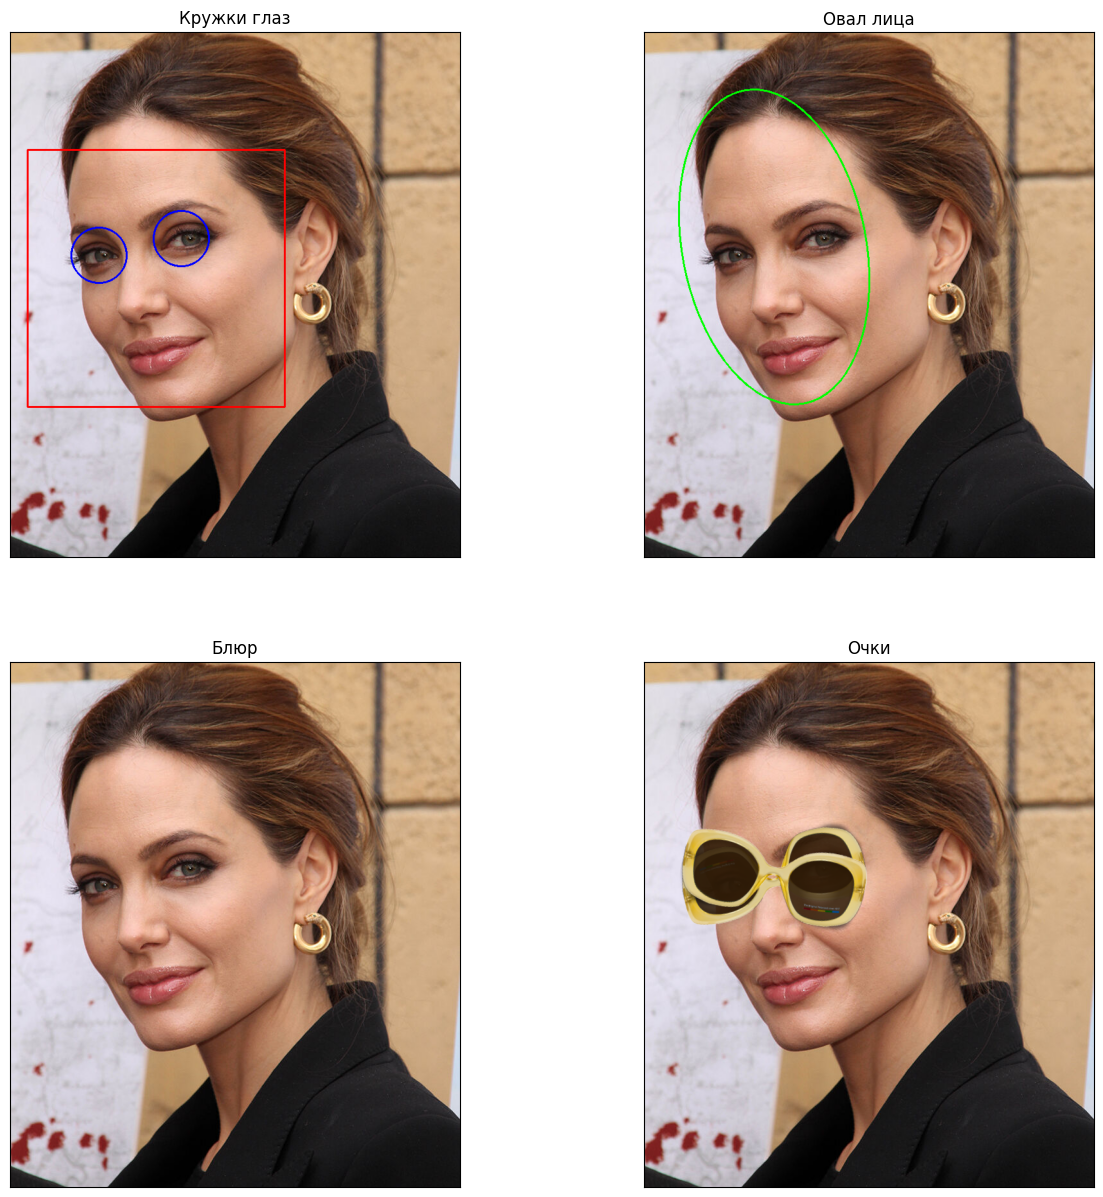

In [263]:
# Вывод изображений

fig, axes = pyplot.subplots(2, 2, figsize=(15, 15))
axes[0, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('Кружки глаз')

axes[0, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Овал лица')

axes[1, 0].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_title('Блюр')

axes[1, 1].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Очки')

pyplot.show()

Text(0.5, 1.0, 'Исходное изображение')

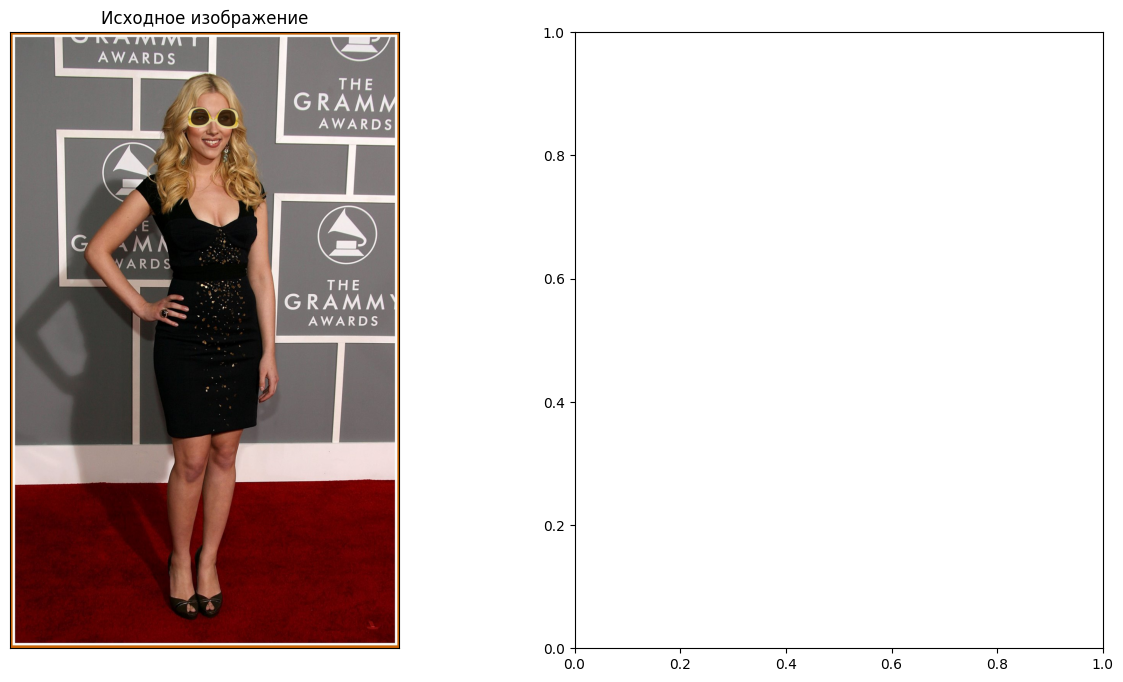

In [247]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

In [ ]:
# !!! УСТАРЕЛО!!!
# выполнение распознавания лица
bboxes = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3, minSize=(50, 50))
# формирование прямоугольника вокруг каждого обнаруженного лица
for box in bboxes:
    #print(box)
    # формирование координат
    x, y, width, height = box
    x2, y2 = x + width, y + height
    # рисование прямоугольников
    cv2.rectangle (img2, (x, y), (x2, y2), (0, 0, 255), 2)

    face = img2[y:y + height, x:x + width] # найденная область с лицом
    facetop = img2[y:int(y + height *2 / 3), x:x + width] # найденная область для поиска глаз

    ###############################
    # поиск глаз 
    ###############################

    # выполнение распознавания глаз
    eyes = classifier_eye.detectMultiScale(facetop)

    for (x_eye,y_eye,w_eye,h_eye) in eyes:
        print(eyes)
        # определяем центр круга
        center = (int(x_eye + 0.5*w_eye), int(y_eye + 0.5*h_eye))

        # вычисляем радиус окружности (подобран эмпирическим путем)
        radius = int(0.3 * (w_eye + h_eye))
        color = (0, 255, 0) # цвет в RGB (интенсивность цветов красный-зеленый-синий от 0 до 255)
        thickness = 3 # толщина линии
        # рисуем круг
        cv2.circle(face, center, radius, color, thickness)
        #перекрестье глаз

        centers = []
        for (x_eye, y_eye, w_eye, h_eye) in eyes:
            cx = int(x_eye + 0.5*w_eye)
            cy = int(y_eye + 0.5*h_eye)
            centers.append((cx, cy))

        if len(centers) >= 2:
            p1, p2 = centers[:2]

            # линия между глазами
            cv2.line(face, p1, p2, (0, 255, 0), 2)

            # середина
            mid = ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)

            # вектор глаза–глаз
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]

            # нормаль
            norm = (dx**2 + dy**2)**0.5
            nx, ny = -dy/norm, dx/norm

            length = int(norm * 1.5)
            p3 = (int(mid[0] + nx * length/2), int(mid[1] + ny * length/2))
            p4 = (int(mid[0] - nx * length/2), int(mid[1] - ny * length/2))

            cv2.line(face, p3, p4, (0, 255, 0), 2)

    ###############################
    # построение овала лица 
    ###############################
        



[[143  66  81  81]
 [ 49  76  73  73]]
[[143  66  81  81]
 [ 49  76  73  73]]
